In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [3]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [171]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len, activation_function):
        
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(self.weights[i].dot(input_layer)+self.biases[i])
                
        
        #mozliwe ze trzeba reshapy
        output_layer=(self.weights[-1].dot(input_layer)+self.biases[-1])
        #print(output_layer.shape)
        self.output_layer=output_layer.T.copy()
        
        
        return(output_layer.T)
        
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8):
        lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=sum((true_output_layer-output_layer)**2)
        print(error)
        iteration=0
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]

        for xd in range(3*10**3):
            iteration+=1

            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #derivative of x is 1
                    errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(self.hidden_layers[i][:,x:x+1])

                for l in range(1,len(self.weights)):

                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    old_gradient_bias[0][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=sum((true_output_layer-output_layer)**2)
            error_list.append(new_error)

            if(iteration % 1000 == 0):
                print(iteration)

            if (abs(new_error-error)/error)<stop:
                print((new_error-error)/error)
                print(iteration)
                break

            error=new_error
        
        return error_list

In [1]:
def Xavier(a,b):
    pass

In [7]:
def linear(X, W):
    return np.c_[np.ones(X.shape[0]), X] @ W

In [116]:
class MLP:
    def __init__(self, inout, af, daf):
        
        self.af = af
        self.daf = daf
        
        self.W = [np.random.randn(inout[i]+1, inout[i+1]) for i in range(len(inout)-1)]
        
    def forward(self, X):
        z=[]
        
        for w in self.W:
            z+=[X]
            X = self.af(linear(X, w))
        
        return X,z
    
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=eps=10**-8):
        
        #feedforward
        z=self.forward(X)
        
        #output error identity function
        errors=[[0]*X.shape[0] for i in range(len(self.W)-1,-1,-1)]
        errors[-1]=(Y-z[0])*daf(linear(z[-1],self.W[-1]))
        for i in range(len(self.W)-2,-1,-1):
            self.W[i+1].T+
            
        
        #gradient descent
        for i in range(len(self.weights)-1,-1,-1):
            self.weights[i]=self.weights[i]-rate
        

In [18]:
test = np.loadtxt("mio1/regression/square-simple-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

In [19]:
X=test[:,0].reshape(-1,1)

In [20]:
Y=test[:,1].reshape(-1,1)

In [58]:
X=np.concatenate((X,3*X-2),axis=1)

In [59]:
Y=np.concatenate((Y,2*Y+1),axis=1)

In [128]:
mlp=MLP(1,1,[15,17,19],sigmoid)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

rate=0.08

beta=0.8

batch=0.2

stop=10**-6

RMSprop=True

eps=10**-8

In [129]:
mlp.train(train_input_layer,true_output_layer)

1000
2000
3000


[array([885.25208707]),
 array([113.00522216]),
 array([128.58682851]),
 array([99.18140217]),
 array([91.03552174]),
 array([96.96549438]),
 array([86.9867021]),
 array([82.58738772]),
 array([81.12737214]),
 array([79.52688795]),
 array([78.1516549]),
 array([76.65206554]),
 array([75.19420219]),
 array([73.88644749]),
 array([72.64257791]),
 array([71.44032708]),
 array([70.28522423]),
 array([69.16750269]),
 array([68.06064598]),
 array([66.93774211]),
 array([65.78837588]),
 array([64.61535394]),
 array([63.42380622]),
 array([62.21706352]),
 array([60.99826432]),
 array([59.77167863]),
 array([58.54163301]),
 array([57.31093488]),
 array([56.0806376]),
 array([54.85098022]),
 array([53.62239108]),
 array([52.39588565]),
 array([51.1729055]),
 array([49.95493553]),
 array([48.74315694]),
 array([47.53824566]),
 array([46.34034941]),
 array([45.14924011]),
 array([43.9645944]),
 array([42.78630854]),
 array([41.61474299]),
 array([40.45082838]),
 array([39.29602669]),
 array([38.15

In [24]:
output_layer=mlp.calculate(train_input_layer)

In [88]:
lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
output_layer=mlp.calculate(train_input_layer)
error=sum((true_output_layer-output_layer)**2)
iteration=0
old_gradient=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
error_list=[error]

for xd in range(2*10**3):
    iteration+=1
    
    for b in range(len(lin)-1):
        
        input_layer=train_input_layer[lin[b]:lin[b+1]]
        output_layer=mlp.calculate(input_layer,memory=True)
        batch_size=output_layer.shape[0]
        errors=[[0]*len(mlp.weights) for x in range(batch_size)]

        for x in range(batch_size):
            #derivative of x is 1
            errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

            for i in range(len(mlp.weights)-2,-1,-1): 
                errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][:,x:x+1])

        for l in range(1,len(mlp.weights)):

            if(RMSprop):
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                mlp.weights[l]=mlp.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))
                
                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
            else:
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                old_gradient[l][b]=new_gradient
                mlp.weights[l]=mlp.weights[l]-new_gradient*rate

                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                old_gradient_bias[l][b]=new_gradient_bias
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*rate

        if(RMSprop):
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
            mlp.weights[0]=mlp.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))
            
            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            old_gradient_bias[0][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
        else:
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
            old_gradient[0][b]=new_gradient
            mlp.weights[0]=mlp.weights[0]-new_gradient*rate

            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
            old_gradient_bias[0][b]=new_gradient_bias
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*rate
        
        
    output_layer=mlp.calculate(train_input_layer)
    new_error=sum((true_output_layer-output_layer)**2)
    error_list.append(new_error)
    
    if(iteration % 1000 == 0):
        print(iteration)
    
    if (abs(new_error-error)/error)<stop:
        print((new_error-error)/error)
        print(iteration)
        break
    
    error=new_error



1000
2000
3000


In [172]:
mlp_start=MLP(1,1,[15,17,19],sigmoid)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [173]:
mlp_vanilla=MLP(1,1,[15,17,19],sigmoid)
mlp_vanilla.weights=mlp_start.weights.copy()
mlp_vanilla.biases=mlp_start.biases.copy()

In [174]:
mlp_RMS=MLP(1,1,[15,17,19],sigmoid)
mlp_RMS.weights=mlp_start.weights.copy()
mlp_RMS.biases=mlp_start.biases.copy()

In [175]:
mlp_vanilla_batch=MLP(1,1,[15,17,19],sigmoid)
mlp_vanilla_batch.weights=mlp_start.weights.copy()
mlp_vanilla_batch.biases=mlp_start.biases.copy()

In [176]:
mlp_momentum=MLP(1,1,[15,17,19],sigmoid)
mlp_momentum.weights=mlp_start.weights.copy()
mlp_momentum.biases=mlp_start.biases.copy()

In [ ]:
mlp.mom

In [177]:
error_momentum=mlp_momentum.train(train_input_layer,true_output_layer)

[271.69752872]
1000
2000
3000


In [178]:
error_vanilla_batch=mlp_vanilla_batch.train(train_input_layer,true_output_layer,beta=0)

[271.69752872]
1000
2000
3000


In [179]:
error_vanilla=mlp_vanilla.train(train_input_layer,true_output_layer,batch=1,beta=0)

[271.69752872]
1000
2000
3000


In [180]:
error_RMS=mlp_RMS.train(train_input_layer,true_output_layer,RMSprop=True)

[271.69752872]
1000
2000
3000


In [113]:
error_list=mlp.train(train_input_layer,true_output_layer)

1000
2000
3000


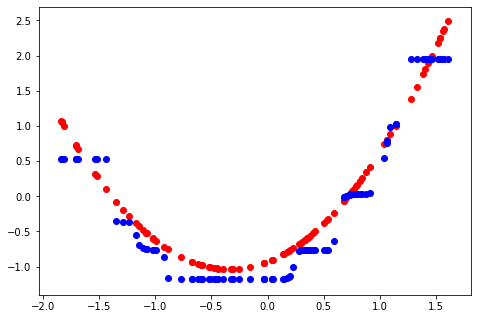

In [130]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [103]:
t = np.arange(1, 3002, 1)

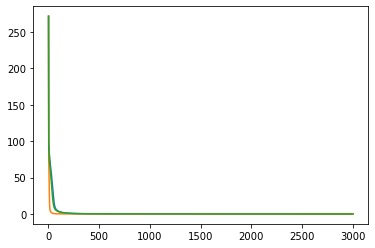

In [184]:
plt.plot(t,error_momentum,t,error_vanilla,t,error_vanilla_batch)

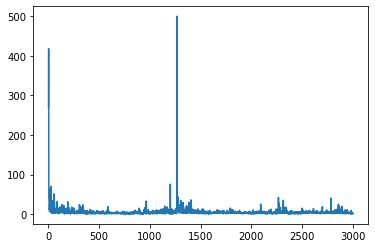

In [183]:
plt.plot(t,error_RMS)

In [49]:
[mlp.hidden_layers[x].shape for x in range(3)]

[(15, 1), (17, 1), (19, 1)]

In [48]:
[errors[0][x].shape for x in range(len(errors[0]))]

[(15, 1), (17, 1), (19, 1), (1, 1)]

In [58]:
[mlp.weights[x].shape for x in range(len(mlp.weights))]

[(15, 19), (17, 15), (19, 17), (1, 19)]

In [57]:
[mlp.biases[x].shape for x in range(len(mlp.weights))]

[(15, 1), (17, 1), (19, 1), (1, 1)]

In [54]:
mlp.output_layer.shape

(100, 1)

In [401]:
((output_layer[0]-true_output_layer[0])*output_layer[0]).reshape(-1,1)

array([[0.02163984]])

In [370]:
len(errors[0])

4

In [371]:
len(errors)

100

In [199]:
mlp.weights[1].shape

(4, 3)

In [73]:
#warstwa neuron pattern
mlp.hidden_layers[0][0]

array([-0.03199908,  0.00470084, -0.25536774,  0.35579902,  0.00207604,
        0.34537689,  0.29979171,  0.13802362,  0.35411896,  0.12422137,
       -0.06211776, -0.05342072, -0.01964256,  0.2325045 , -0.25438486,
        0.20906782,  0.16237478, -0.16799066, -0.1093466 ,  0.0560442 ,
        0.16128476,  0.36185598,  0.21608555,  0.09004325,  0.27493971,
       -0.15610197, -0.10268811,  0.2608824 ,  0.17277385, -0.12275886,
       -0.25173919, -0.18808972, -0.138532  ,  0.03318402, -0.15092045,
        0.18984732, -0.27465792, -0.03465583,  0.05604079, -0.27878033,
        0.09991191, -0.17671256, -0.04540331,  0.14171443,  0.22671384,
        0.08818804, -0.12722544, -0.22105923, -0.22391131, -0.08053474,
        0.15594371, -0.27964974, -0.14363456,  0.3293536 ,  0.32452923,
        0.19946977, -0.06234968,  0.05646883,  0.20592045,  0.12443097,
        0.12905735, -0.1380278 , -0.13841325, -0.02587128,  0.33550476,
        0.3486618 ,  0.203231  ,  0.19891587,  0.06998212, -0.27

In [324]:
mlp.train(X,Y)

[[6.68602948e-01]
 [6.10105933e-01]
 [3.47440350e-04]
 ...
 [6.10151439e-01]
 [6.10194959e-01]
 [6.10171751e-01]]


In [ ]:
pd.read_csv

In [107]:
#test=pd.read_csv("mio1/regression/steps-large-training.csv",delimiter=",")

In [38]:
test = np.loadtxt("mio1/regression/square-simple-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

In [40]:
test

array([[-1.71542658e-01, -1.27351580e+02],
       [ 2.52005474e-02, -1.29942844e+02],
       [-1.36899138e+00,  3.86723671e+01],
       [ 1.90738970e+00,  1.97432191e+02],
       [ 1.11293711e-02, -1.29988852e+02],
       [ 1.85151809e+00,  1.78530731e+02],
       [ 1.60714217e+00,  1.02461536e+02],
       [ 7.39925693e-01, -8.07258972e+01],
       [ 1.89838314e+00,  1.94347268e+02],
       [ 6.65933726e-01, -9.00879046e+01],
       [-3.33004761e-01, -1.20019705e+02],
       [-2.86381131e-01, -1.22618726e+02],
       [-1.05301060e-01, -1.29002052e+02],
       [ 1.24642471e+00,  9.82171130e+00],
       [-1.36372228e+00,  3.73764614e+01],
       [ 1.12078385e+00, -1.69459202e+01],
       [ 8.70468906e-01, -6.18055496e+01],
       [-9.00574844e-01, -5.70068456e+01],
       [-5.86192127e-01, -9.90740912e+01],
       [ 3.00445271e-01, -1.21875938e+02],
       [ 8.64625461e-01, -6.27180531e+01],
       [ 1.93986019e+00,  2.08675181e+02],
       [ 1.15840494e+00, -9.22882029e+00],
       [ 4.

In [109]:
test=test[["x","y"]]

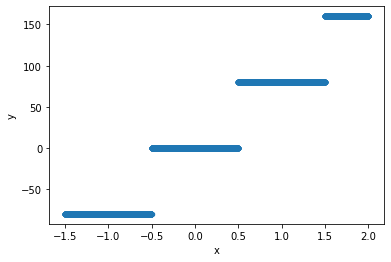

In [114]:
test.plot.scatter(x="x",y="y")

In [263]:
test_mlp=MPL(1,1,[5],sigmoid)

In [264]:
test_mlp.calculate(X)

array([[0.92611473],
       [3.68774105],
       [2.40454252],
       ...,
       [3.46152408],
       [3.2786449 ],
       [3.37272737]])

In [127]:
X=np.vstack(test["x"].to_numpy())

In [177]:
Y_hat=test_mpl.output_layer

In [178]:
Y=np.vstack(test["y"].to_numpy())

In [179]:
sum((Y-Y_hat)**2)

array([70884723.61747867])

In [193]:
np.random.random((1,5))

array([[0.79744999, 0.46417824, 0.5293035 , 0.29351545, 0.87100363]])

In [246]:
Y.min()

-80

In [450]:
test_mlp=MLP(1,1,[4],sigmoid)

In [437]:
test_mlp.weights[0]=np.ones(test_mlp.weights[0].shape)

In [449]:
X.shape

(100, 1)

In [461]:
test_mlp=MLP(1,1,[7],sigmoid)

test_mlp.weights[0]=np.ones(test_mlp.weights[0].shape)
test_mlp.weights[1]=np.ones(test_mlp.weights[1].shape)


test_mlp.calculate(X)
Y_hat=test_mlp.output_layer

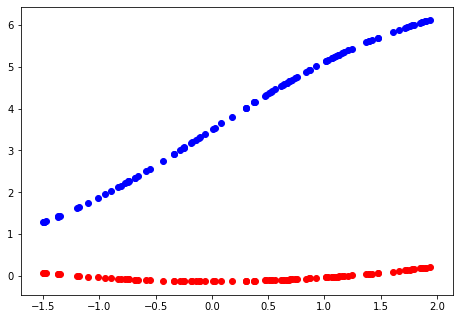

In [462]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X, Y/1000, color='r')
ax.scatter(X,Y_hat,color="b")

In [441]:
Y_hat

array([[0.61455317],
       [0.62361713],
       [0.56344802],
       [0.69348409],
       [0.62297084],
       [0.69207034],
       [0.68538074],
       [0.65494235],
       [0.69325905],
       [0.65190051],
       [0.60711992],
       [0.60926169],
       [0.61760904],
       [0.67396656],
       [0.56364096],
       [0.66956171],
       [0.66015699],
       [0.58194688],
       [0.59563138],
       [0.63610668],
       [0.65992791],
       [0.69428635],
       [0.67090344],
       [0.64412731],
       [0.68137991],
       [0.58465246],
       [0.5972317 ],
       [0.67900524],
       [0.66232126],
       [0.59243281],
       [0.56416212],
       [0.57746614],
       [0.5887193 ],
       [0.63058906],
       [0.58584363],
       [0.66578922],
       [0.55973707],
       [0.61389619],
       [0.63610586],
       [0.55896291],
       [0.64640463],
       [0.57998757],
       [0.61124012],
       [0.65574548],
       [0.6728985 ],
       [0.64369644],
       [0.59137567],
       [0.570